# Robotics and Machine Vision – Image Warping Lab

Last edited by Nadejda Roubtsova for September - October 2023 

This lab will explore image warping.

You should download the **supporting images** `mona.jpg` and `windows.jpg` from the assignment's webpage, and put them into the same directory as this notebook.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## Make figures larger.
plt.rcParams['figure.figsize'] = [10, 6]

## Try commenting this out if plots look blurry on your screen.
%config InlineBackend.figure_format = 'retina'


## 1. Forward mapping [15 marks]

Let us start by implementing image warping using forward mapping.
Every pixel in the source image is transformed to the target image independently. You will see that this approach leads to gaps between the transformed pixels in the target image.



Let's first load the image and define an example warping transformation for this assignment:

In [3]:
source = plt.imread('mona.jpg') / 255.

## Basic transformations to manipulate the source image.
T = np.array([[1, 0, -source.shape[1] / 2],
              [0, 1, -source.shape[0] / 2],
              [0, 0, 1]])
t = np.pi / 4
R = np.array([[np.cos(t), -np.sin(t), 0],
              [np.sin(t),  np.cos(t), 0],
              [ 0, 0, 1]])
S = np.diag([2, 2, 1])

## The warping transformation (rotation about arbitrary point).
M = np.linalg.inv(T) @ R @ S @ T

<span style="color:red"> **For you to do:** </span>

**a) Implement a function to transform a point (x, y) using a homogeneous 2D transform matrix, rounding to the nearest pixel. [5 marks]**

In [4]:
def transform_pixel_nn(x, y, transform):
    """Transforms a source pixel coordinate (x, y) using 'transform', and rounds to the nearest pixel
    coordinate. Returns a tuple (x', y')."""
    # Create the homogeneous coordinate for the point (x, y)
    point = np.array([x, y, 1])
    
    # Perform the matrix multiplication
    transformed_point = np.dot(transform, point)
    
    # Extract the x' and y' coordinates
    x_prime = transformed_point[0]
    y_prime = transformed_point[1]
    
    # Round to the nearest pixel
    x_prime_rounded = round(x_prime)
    y_prime_rounded = round(y_prime)
    
    return (x_prime_rounded, y_prime_rounded)

<span style="color:red"> **For you to do:** </span>

**b) Implement forward mapping using your per-pixel transform function. The pixel grid is meant to be kept consistent between the source and target. [10 marks]**

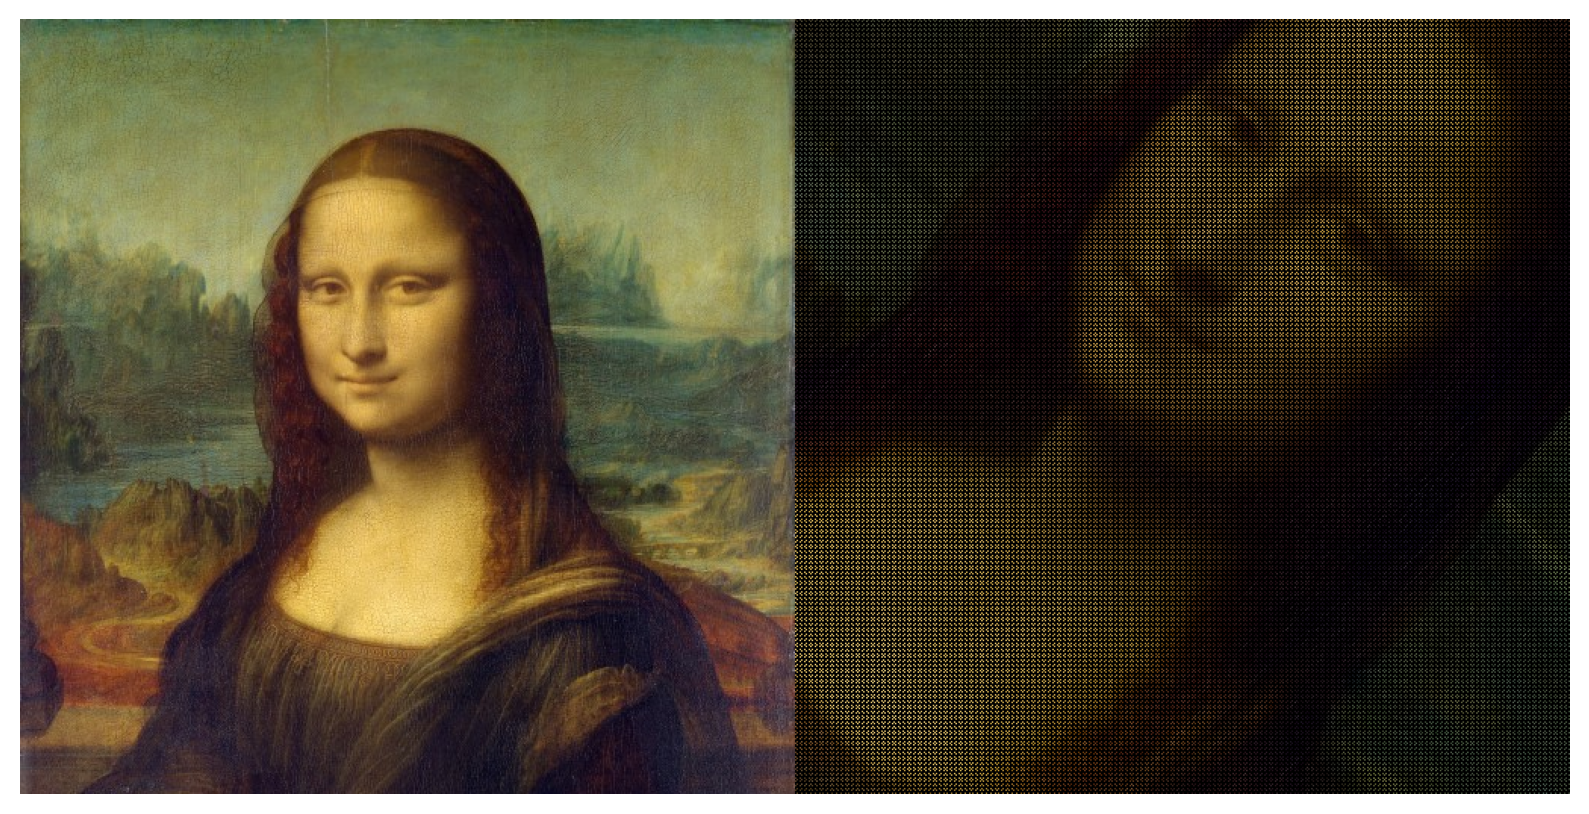

In [5]:
def forward_mapping(source, transform):
    """Warps the 'source' image by the given 'transform' using forward mapping."""
    height, width = source.shape[:2]
    target = np.zeros_like(source)
    
    for y in range(height):
        for x in range(width):
            x_prime, y_prime = transform_pixel_nn(x, y, transform)
            
            if 0 <= x_prime < width and 0 <= y_prime < height:
                target[y_prime, x_prime] = source[y, x]
    
    return target

## Visualise input (left) and warped output (right).
target = forward_mapping(source, M)
plt.imshow(np.hstack([source, target]))
plt.axis("off");


## 2. Backward mapping [20 marks]

<span style="color:red"> **For you to do:** </span>

**a) Using the `transform_pixel_nn` function from your implementation of forward mapping implement backward mapping in the code cell below using the same 2D transformation `M`.**

Backward mapping computes for each **target image pixel** where in the source image it originats from, and, in its simplest form, uses the colour sampled from the nearest pixel. Note that this operation should not leave any gaps in the warped image.

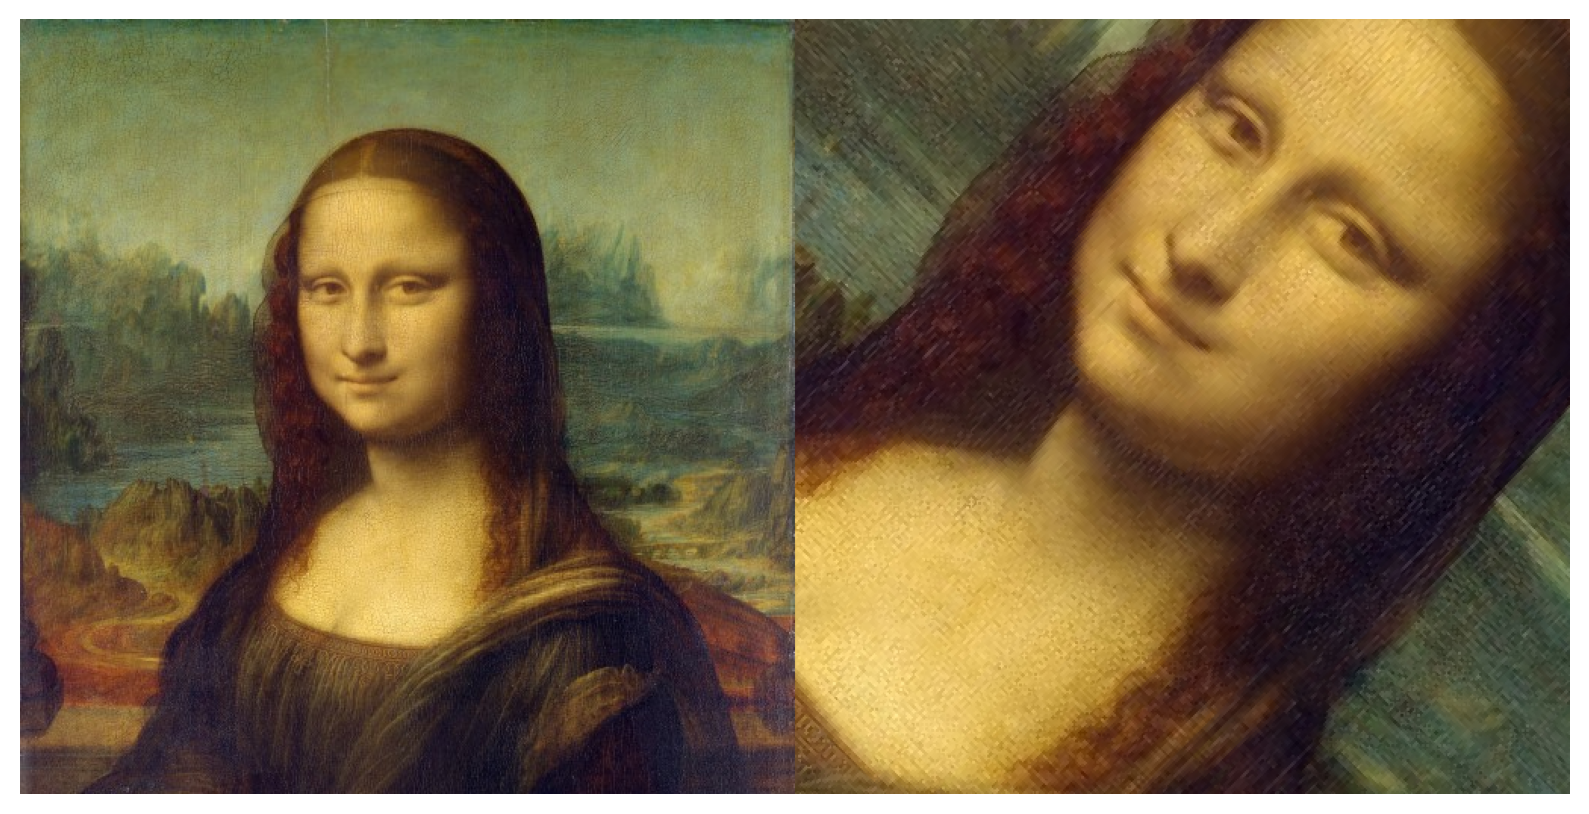

In [6]:
def backward_mapping(source, transform):
    """Warps the 'source' image by the given 'transform' using backward mapping with nearest-neighbour interpolation."""
    height, width = source.shape[:2]
    target = np.zeros_like(source)
    
    # Calculate the inverse of the transform matrix
    inverse_transform = np.linalg.inv(transform)
    
    for y in range(height):
        for x in range(width):
            # Apply the inverse transform to find the corresponding source coordinates
            x_prime, y_prime = transform_pixel_nn(x, y, inverse_transform)
            
            # Check if the calculated coordinates are within the source image boundaries
            if 0 <= x_prime < width and 0 <= y_prime < height:
                target[y, x] = source[y_prime, x_prime]
    
    return target


## Visualise input (left) and warped output (right).
target = backward_mapping(source, M)
plt.imshow(np.hstack([source, target]))
plt.axis("off");

## 3. Linear interpolation [20 marks]

<span style="color:red"> **For you to do:** </span>

**a) In the code cell below, modify your backward mapping function from part 2 to sample pixel colours from the source image using bilinear interpolation. [15 marks]**

**b) Handle the edge cases carefully for full marks. Specifically, implement the "fading to black" effect at the edges of the interpolated image by carefully considering how to handle the off-the-image grid pixels of the source image during interpolation. [5 marks]**

**Hint:** For validation, it may be helpful to use the transformations `M` commented out in the code cell below.

Interpolation must be implemented from scratch, not using any exisiting library functions. Note that interpolation may require a different precision of mapping and/or rounding approach to anchor to the pixel grid. So, in this question, feel free **not** to use `transform_pixel_nn` from Q1 a), which rounds off to the nearest pixel, or to write a *modified* version of the function.

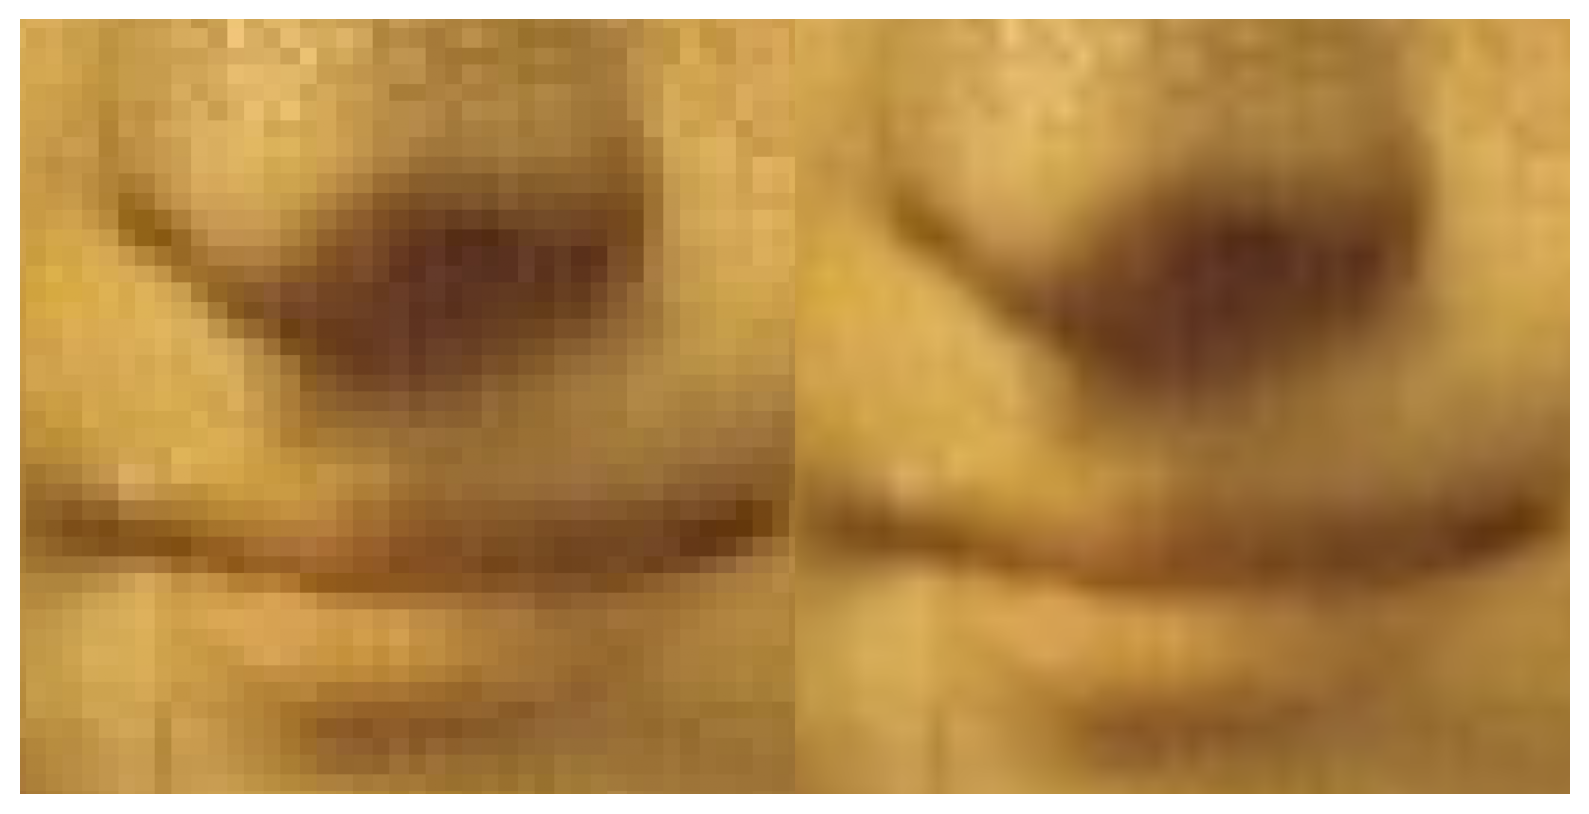

In [7]:
def backward_mapping_bilinear(source, transform):
    """Warps the 'source' image by the given 'transform' using backward mapping with bilinear interpolation."""
    height, width = source.shape[:2]
    target = np.zeros_like(source)
    
    # Calculate the inverse of the transform matrix
    inverse_transform = np.linalg.inv(transform)
    
    for y in range(height):
        for x in range(width):
            # Apply the inverse transform to find the corresponding source coordinates
            point = np.array([x, y, 1])
            transformed_point = np.dot(inverse_transform, point)
            x_prime = transformed_point[0]
            y_prime = transformed_point[1]
            
            if 0 <= x_prime < width and 0 <= y_prime < height:
                # Bilinear interpolation
                x0 = int(np.floor(x_prime))
                x1 = min(x0 + 1, width - 1)
                y0 = int(np.floor(y_prime))
                y1 = min(y0 + 1, height - 1)
                
                # Compute the weights
                dx = x_prime - x0
                dy = y_prime - y0
                
                # Interpolate the pixel value
                top = (1 - dx) * source[y0, x0] + dx * source[y0, x1]
                bottom = (1 - dx) * source[y1, x0] + dx * source[y1, x1]
                value = (1 - dy) * top + dy * bottom
                
                target[y, x] = value
            else:
                # Fading to black for out-of-bounds coordinates
                target[y, x] = 0
    
    return target


## Compare nearest-neighbour (left) and bilinear interpolation (right) side by side.
M = np.array([[12, 0, -2486], [0, 12, -2508], [0, 0, 1]])  # big smile
# M = np.array([[40, 0, 80], [0, 40, 80], [0, 0, 1]])  # check edge handling
target_nearest  = backward_mapping(source, M)
target_bilinear = backward_mapping_bilinear(source, M)
plt.imshow(np.hstack([target_nearest, target_bilinear]))
plt.axis("off");


## 4. Lens undistortion [45 marks]

In this part of the assignment, you will apply a different warping function, speficifically one that can be used to remove lens distortion from images. The visual effect of such *un-*distortion is rectification of lines so that they appear straight again.

Undistortion is to be implemented via backward mapping. To this end, consider the steps to map a target image location $(u,v)$ onto the source image location $(u', v')$ using the *polynomial lens distortion model*:

$$\begin{align}
x &= (u - p_x) / f_x \\
y &= (v - p_y) / f_y \\
r^2 &= x^2 + y^2 \\
x' &= x \cdot (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) \\
y' &= y \cdot (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) \\
u' &= x' \cdot f_x + p_x \\
v' &= y' \cdot f_y + p_y
\end{align}$$

In the mapping above:
* $f_x$ and $f_y$ are the focal lengths of the camera
* $(p_x, p_y)$ is called the *principal point* or *centre of projection*
* $k_1$, $k_2$, $k_3$ are the *lens distortion coefficients*

Further please note that:
* The `camera_matrix` is defined as:

  $\mathbf{K} = \begin{bmatrix}f_x & 0 & p_x \\ 0 & f_y & p_y \\ 0 & 0 & 1\end{bmatrix}$.
  

* `dist_coeffs` is the lens distortion coefficients $\begin{bmatrix}k_1 & k_2 & k_3\end{bmatrix}$ .

<span style="color:red"> **For you to do:** </span>

**a) Implement the steps of the polynomial distortion model detailed above in the function below to calculate the source image location $(u', v')$  for a single given pixel $(u,v)$ of the target (undistorted) image. [5 marks]**



In [8]:
def undistort_point(u, v, camera_matrix, dist_coeffs):
    """Given camera matrix and distortion coefficients, finds the corresponding undistorted (source) pixel location (u', v') 
    for a given (target) pixel location (u,v)."""
    fx, fy = camera_matrix[0, 0], camera_matrix[1, 1]
    px, py = camera_matrix[0, 2], camera_matrix[1, 2]
    k1, k2, k3 = dist_coeffs
    
    # Step 1: Normalize the coordinates
    x = (u - px) / fx
    y = (v - py) / fy
    
    # Step 2: Compute r^2
    r2 = x**2 + y**2
    r4 = r2**2
    r6 = r2**3
    
    # Step 3: Compute the distortion factor
    distortion = 1 + k1 * r2 + k2 * r4 + k3 * r6
    
    # Step 4: Apply the distortion factor
    x_prime = x * distortion
    y_prime = y * distortion
    
    # Step 5: Convert back to pixel coordinates
    u_prime = x_prime * fx + px
    v_prime = y_prime * fy + py
    
    return u_prime, v_prime

<span style="color:red"> **For you to do:** </span>

**b) Using your function `undistort_point` above, in the code cell below implement polynomial lens undistortion for a given image via backward mapping with bilinear interpolation. [15 marks]**


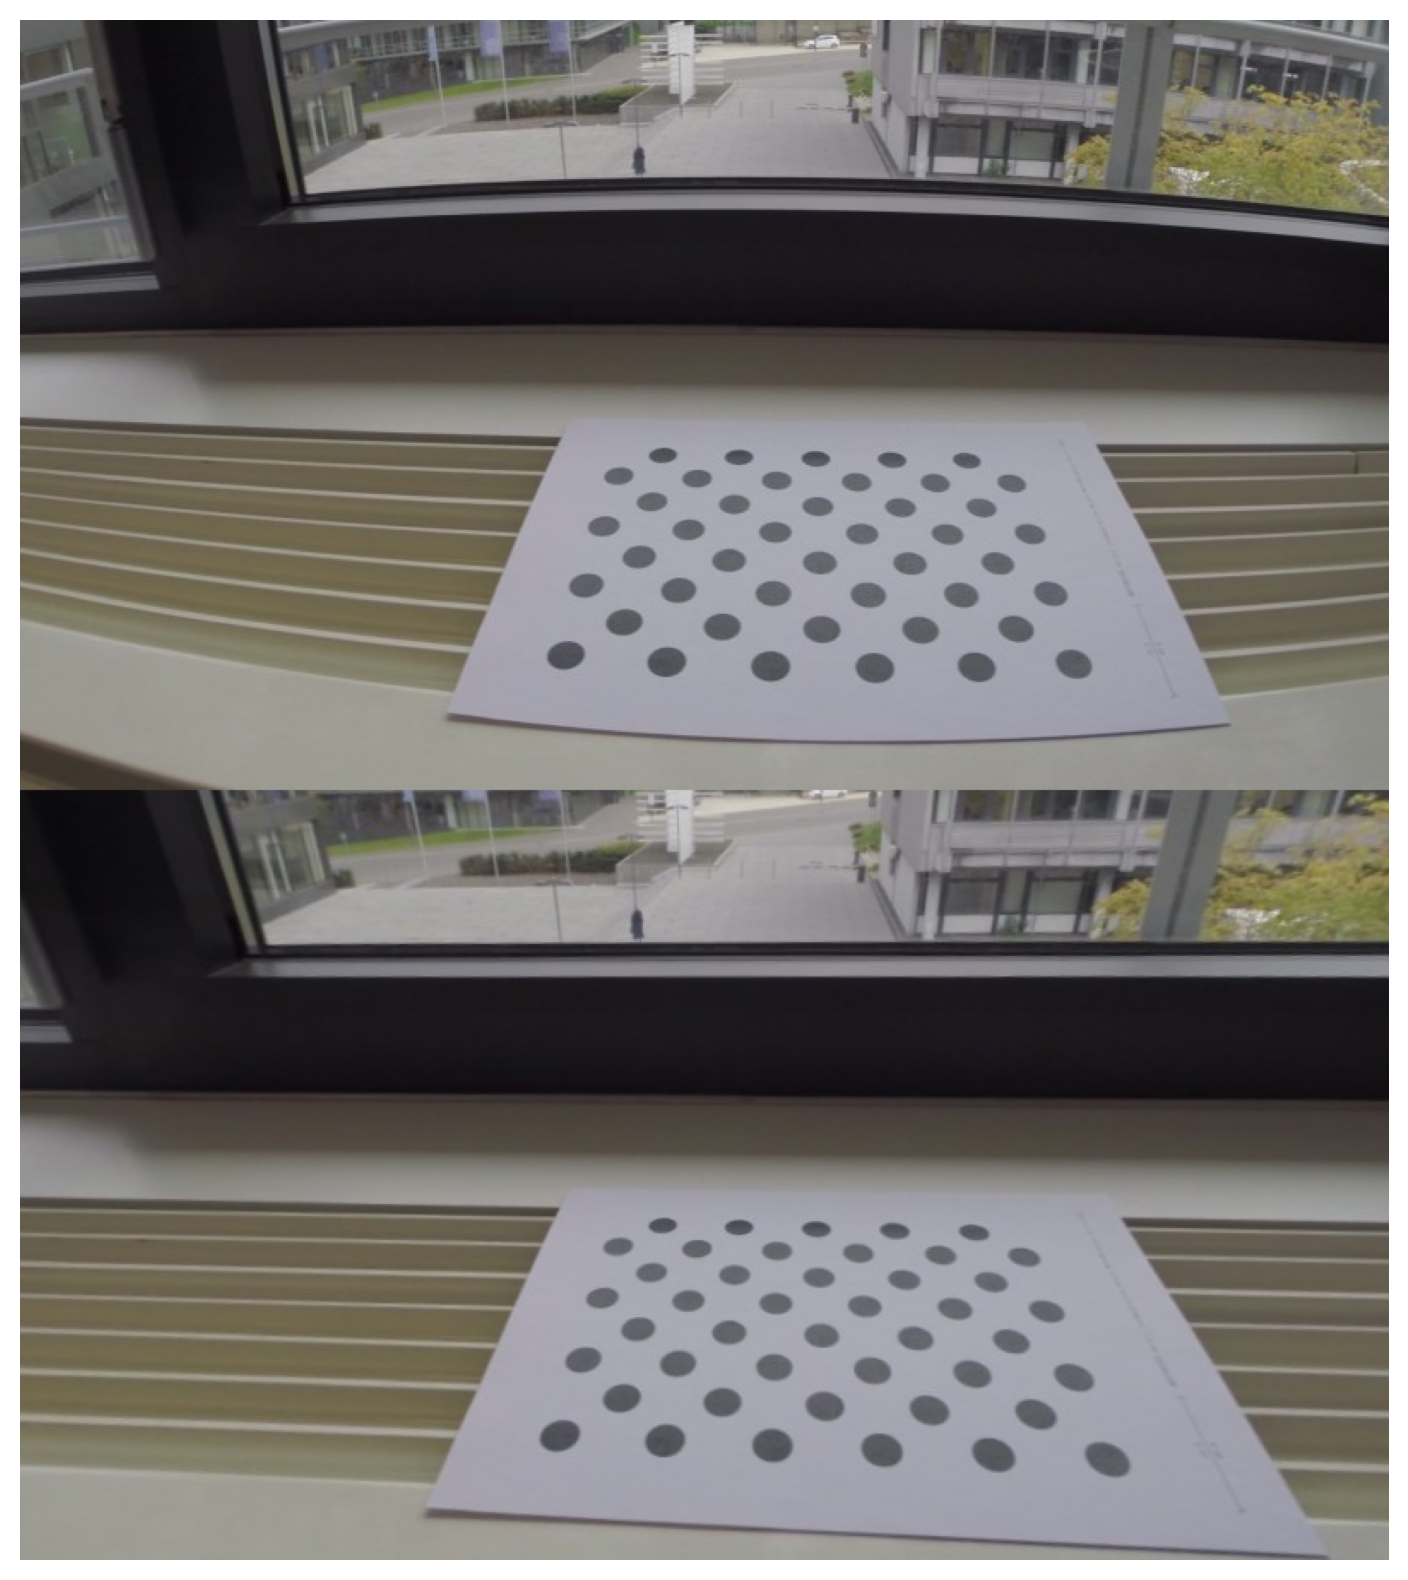

In [9]:
def bilinear_interpolation(image, x, y):
    """Performs bilinear interpolation for the given coordinates."""
    height, width = image.shape[:2]
    
    x0 = int(np.floor(x))
    x1 = min(x0 + 1, width - 1)
    y0 = int(np.floor(y))
    y1 = min(y0 + 1, height - 1)
    
    if x0 < 0 or x1 >= width or y0 < 0 or y1 >= height:
        return 0
    
    Ia = image[y0, x0]
    Ib = image[y0, x1]
    Ic = image[y1, x0]
    Id = image[y1, x1]
    
    wa = (x1 - x) * (y1 - y)
    wb = (x - x0) * (y1 - y)
    wc = (x1 - x) * (y - y0)
    wd = (x - x0) * (y - y0)
    
    return wa * Ia + wb * Ib + wc * Ic + wd * Id


def undistort_image(image, camera_matrix, dist_coeffs):
    """Undistorts an image using the given camera matrix and distortion coefficients."""
    height, width = image.shape[:2]
    target = np.zeros_like(image)
    
    for v in range(height):
        for u in range(width):
            u_prime, v_prime = undistort_point(u, v, camera_matrix, dist_coeffs)
            
            if 0 <= u_prime < width and 0 <= v_prime < height:
                target[v, u] = bilinear_interpolation(image, u_prime, v_prime)
            else:
                target[v, u] = 0
    
    return target


## The intrinsic camera matrix and lens undistortion coefficients for the test image.
source = plt.imread('window.jpg') / 255.
camera_matrix = np.array([[474.53, 0, 405.96], [0, 474.53, 217.81], [0, 0, 1]])
dist_coeffs = np.array([-0.27194, 0.11517, -0.029859])

## Visualise input (top) and undistorted output (bottom).
target = undistort_image(source, camera_matrix, dist_coeffs)
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(np.vstack([source, target]))
plt.axis("off");

<span style="color:red"> **For you to do:** </span>

**c) Implement fast image undistortion using vectorisation, without any for-loops. Your function should run in less than 3 seconds. [25 marks]**

Remember that the vectorised version of your undistortion function must be functionally identical to the original. This means the function must also perform bilinear interpolation.


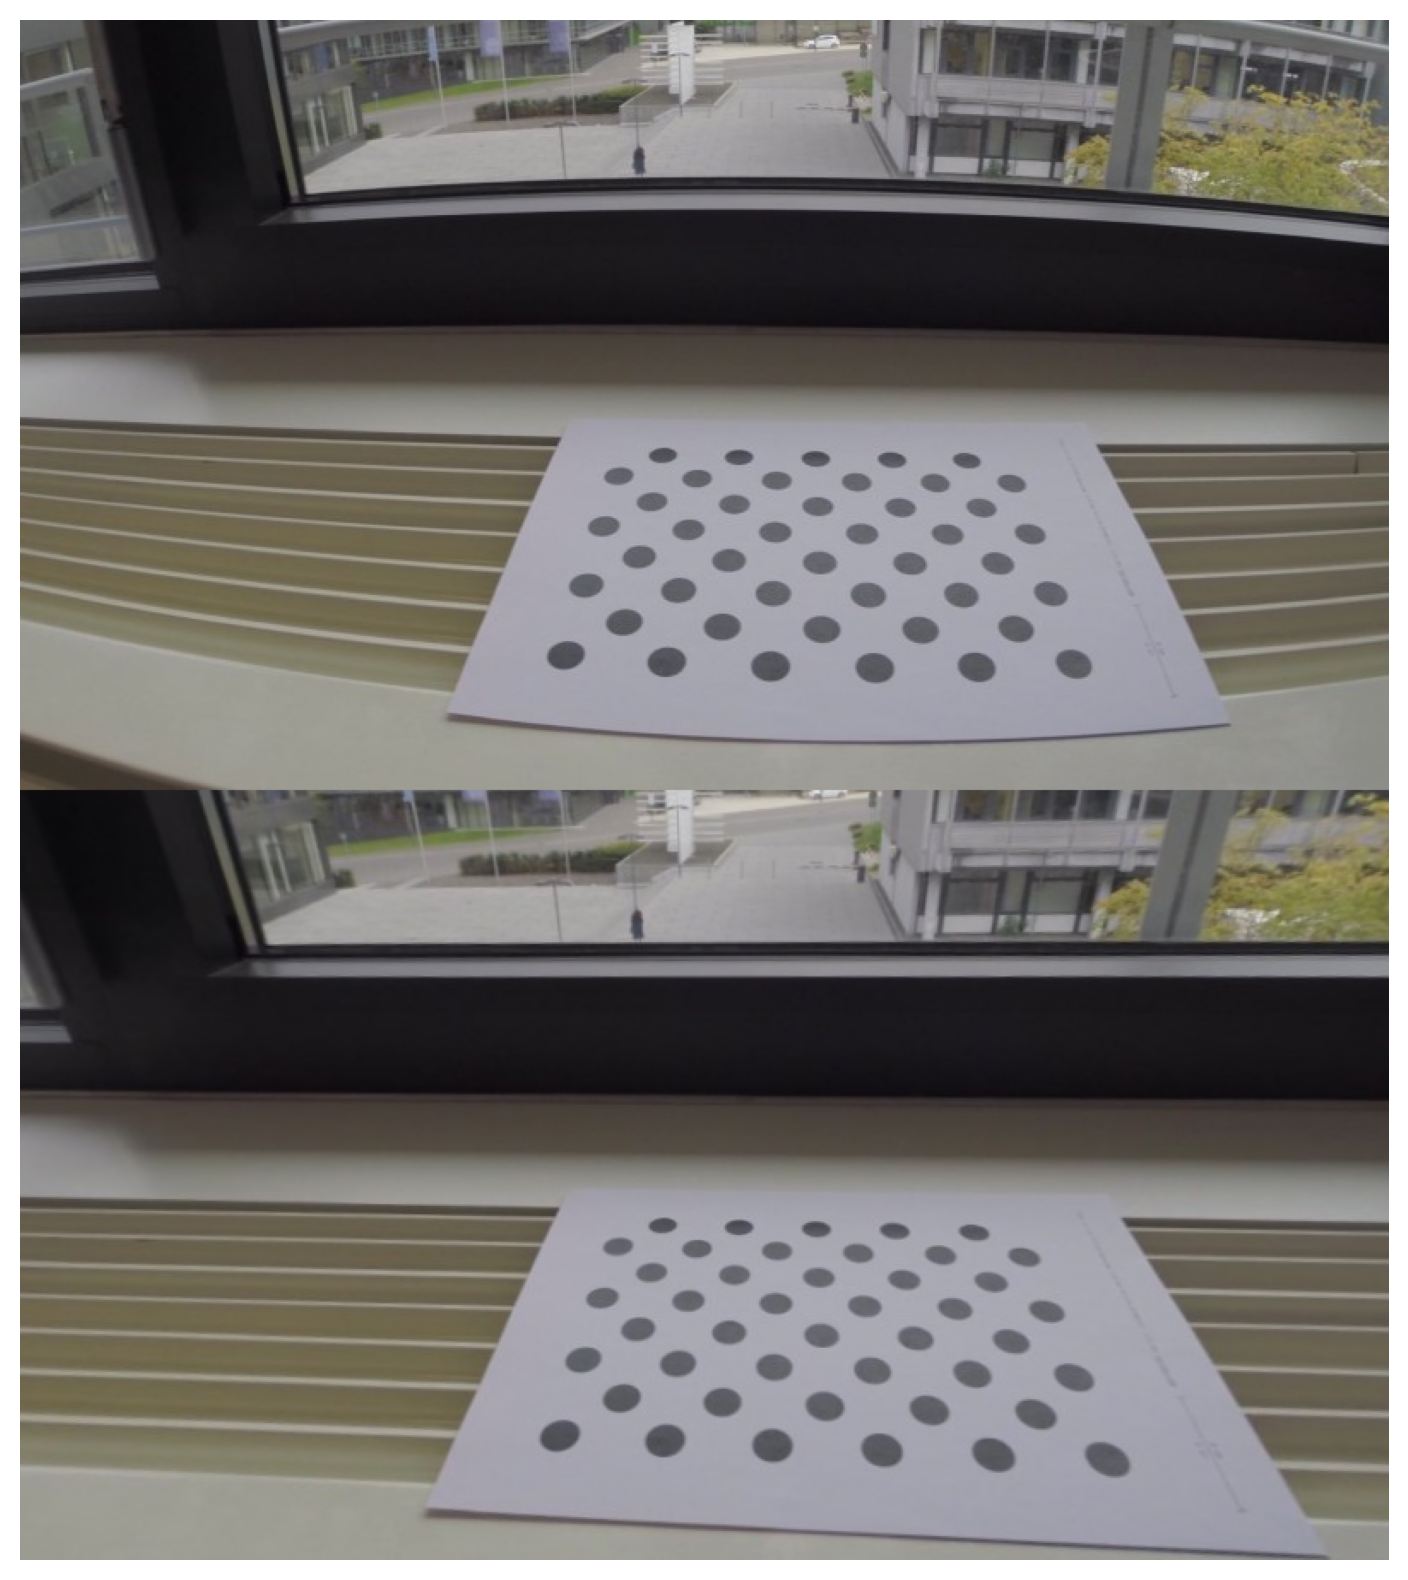

In [10]:
def undistort_image_vectorised(image, camera_matrix, dist_coeffs):
    """Undistorts an image using the given camera matrix and distortion coefficients.
    Use vectorised operations to avoid slow for-loops."""
    height, width = image.shape[:2]
    fx, fy = camera_matrix[0, 0], camera_matrix[1, 1]
    px, py = camera_matrix[0, 2], camera_matrix[1, 2]
    k1, k2, k3 = dist_coeffs
    
    # Create meshgrid for pixel coordinates
    u, v = np.meshgrid(np.arange(width), np.arange(height))
    
    # Step 1: Normalize the coordinates
    x = (u - px) / fx
    y = (v - py) / fy
    
    # Step 2: Compute r^2, r^4, and r^6
    r2 = x**2 + y**2
    r4 = r2**2
    r6 = r2**3
    
    # Step 3: Compute the distortion factor
    distortion = 1 + k1 * r2 + k2 * r4 + k3 * r6
    
    # Step 4: Apply the distortion factor
    x_prime = x * distortion
    y_prime = y * distortion
    
    # Step 5: Convert back to pixel coordinates
    u_prime = x_prime * fx + px
    v_prime = y_prime * fy + py
    
    # Perform bilinear interpolation
    x0 = np.floor(u_prime).astype(int)
    x1 = np.clip(x0 + 1, 0, width - 1)
    y0 = np.floor(v_prime).astype(int)
    y1 = np.clip(y0 + 1, 0, height - 1)
    
    dx = u_prime - x0
    dy = v_prime - y0
    
    # Ensure coordinates are within bounds
    x0 = np.clip(x0, 0, width - 1)
    y0 = np.clip(y0, 0, height - 1)
    
    # Get pixel values for interpolation
    Ia = image[y0, x0]
    Ib = image[y0, x1]
    Ic = image[y1, x0]
    Id = image[y1, x1]
    
    # Compute the interpolated values
    wa = (1 - dx) * (1 - dy)
    wb = dx * (1 - dy)
    wc = (1 - dx) * dy
    wd = dx * dy
    
    target = wa[..., None] * Ia + wb[..., None] * Ib + wc[..., None] * Ic + wd[..., None] * Id
    
    # Handle edge cases by setting out-of-bounds pixels to black
    out_of_bounds = (u_prime < 0) | (u_prime >= width) | (v_prime < 0) | (v_prime >= height)
    target[out_of_bounds] = 0
    
    return target

# Visualise input (top) and undistorted output (bottom).
target = undistort_image_vectorised(source, camera_matrix, dist_coeffs)
plt.rcParams['figure.figsize'] = [10, 10]
plt.imshow(np.vstack([source, target]))
plt.axis("off");